In [4]:
%pip install matplotlib
%pip install torch
%pip install torchvision


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/35/3a/a39f354fa3119785be87e2f94ffa2620f8a270c8560f7356358ee62fb4c5/torch-2.3.0-cp311-cp311-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/41/24/0b023b6537dfc9bae2c779353998e3e99ac7dfff4222fc6126650e93c3f3/filelock-3.14.0-py3-none-any.whl.metadata
  Obtaining dependency information for sympy from https://files.pythonhosted.org/packages/d2/05/e6600db80270777c4a64238a98d442f0fd07cc8915be2a1c16da7f2b9e74/sympy-1.12-py3-none-any.whl.metadata
  Obtaining dependency information for networkx from https://files.pythonhosted.org/packages/38/e9/5f72929373e1a0e8d142a130f3f97e6ff920070f87f91c4e13e40e0fba5a/networkx-3.3-py3-none-any.whl.metadata
  Obtaining depe

In [6]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [7]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [9]:
train_dir='train'
test_dir='test'
valid_dir='valid'

# Create Dataset and DataLoaders

In [14]:
import os
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

NUM_WORKERS= os.cpu_count()

def create_dataloaders(
        train_dir : str,
        test_dir : str,
        transform : transforms.Compose,
        batch_size : int,
        num_workers : int = NUM_WORKERS,
):
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)
    class_name=train_data.classes

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader,class_name


In [15]:
IMG_SIZE=224

manual_transforms=transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
])

print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [18]:
BATCH_SIZE=18


train_loader, test_loader , class_name= create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
)

train_loader,test_loader,class_name

(<torch.utils.data.dataloader.DataLoader at 0x7f9af0b42b90>,
 ['Bush Clock Vine',
  'Common Lanthana',
  'Datura',
  'Hibiscus',
  'Jatropha',
  'Marigold',
  'Nityakalyani',
  'Rose',
  'Yellow_Daisy',
  'adathoda',
  'banana',
  'champaka',
  'chitrak',
  'crown flower',
  "four o'clock flower",
  'honeysuckle',
  'indian mallow',
  'malabar melastome',
  'nagapoovu',
  'pinwheel flower',
  'shankupushpam',
  'spider lily',
  'sunflower',
  'thechi',
  'thumba',
  'touch me not',
  'tridax procumbens',
  'wild_potato_vine'])

Image shape: torch.Size([3, 224, 224])
Label: 5


(-0.5, 223.5, 223.5, -0.5)

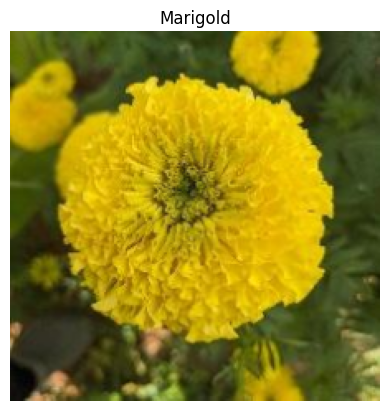

In [21]:
image_batch, label_batch = next(iter(train_loader))

image,label=image_batch[0],label_batch[0]

print(f'Image shape: {image.shape}')
print(f'Label: {label}')

plt.imshow(image.permute(1,2,0))
plt.title(class_name[label])
plt.axis('off')

In [30]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        super().__init__()
        self.patch_size = patch_size
        self.patcher = nn.Conv2d(in_channels=in_channels,out_channels= emb_size, kernel_size=patch_size, stride=patch_size,padding=0)

        self.flatten = nn.Flatten(start_dim=2,end_dim=3)

    def forward(self, x):
        image_resolution  = x.shape[-1]
        assert image_resolution % self.patch_size ==0, f"Input image size must be divisible by patch size,image shape :{image_resolution}"
        
        x_patched= self.patcher(x)
        x_flattend = self.flatten(x_patched)

        return x_flattend.permute(0,2,1)

In [31]:
patch_size =16

def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seeds()

patchify=PatchEmbedding(in_channels=3,patch_size=16,emb_size=768)

print(f'Input Image shape :{image.unsqueeze(0).shape}')
patch_embedded_image= patchify(image.unsqueeze(0))
print(f'Output Patch Embedded Image shape :{patch_embedded_image.shape}')

Input Image shape :torch.Size([1, 3, 224, 224])
Output Patch Embedded Image shape :torch.Size([1, 196, 768])


In [32]:
print(patch_embedded_image)

tensor([[[-0.3885,  0.1096, -0.1192,  ...,  0.2504, -0.1748,  0.1631],
         [-0.3233,  0.0755, -0.1009,  ...,  0.2294, -0.1785,  0.1632],
         [-0.3080,  0.0882, -0.1218,  ...,  0.2124, -0.1565,  0.0712],
         ...,
         [-0.2251,  0.0327, -0.1626,  ...,  0.2122, -0.1069,  0.1160],
         [-0.3304,  0.1151, -0.1447,  ...,  0.2414, -0.1096,  0.1181],
         [-0.5254,  0.1116, -0.1744,  ...,  0.4841, -0.2675,  0.1471]]],
       grad_fn=<PermuteBackward0>)


In [39]:
set_seeds()

patch_size=16

print(f'Image tensor shape: {image.shape}')
height,width = image.shape[1], image.shape[2]

x=image.unsqueeze(0)
print(f'Input Image shape: {x.shape}')

patch_embed = PatchEmbedding(in_channels=3, patch_size=patch_size, emb_size=768)
patch_embedded_image = patch_embed(x)
print(f'Patching embedding shape:{patch_embedded_image.shape}')

## create class token embedding 
batch_size= patch_embedded_image.shape[0]
embedding_dimension= patch_embedded_image.shape[-1]
class_token= nn.Parameter(torch.ones(batch_size,1,embedding_dimension),requires_grad=True)
print(f'Class token shape: {class_token.shape}')


## prepend class token embedding to patch embedding
patch_embedded_class_token=torch.cat([class_token,patch_embedded_image],dim=1)
print(f'Patched embedded class token shape: {patch_embedded_class_token.shape}')

## create position embedding
number_of_patches = int ((height* width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),requires_grad=True)

##ADD position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedded_class_token + position_embedding
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

print(patch_embedded_class_token)

Image tensor shape: torch.Size([3, 224, 224])
Input Image shape: torch.Size([1, 3, 224, 224])
Patching embedding shape:torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patched embedded class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.3885,  0.1096, -0.1192,  ...,  0.2504, -0.1748,  0.1631],
         [-0.3233,  0.0755, -0.1009,  ...,  0.2294, -0.1785,  0.1632],
         ...,
         [-0.2251,  0.0327, -0.1626,  ...,  0.2122, -0.1069,  0.1160],
         [-0.3304,  0.1151, -0.1447,  ...,  0.2414, -0.1096,  0.1181],
         [-0.5254,  0.1116, -0.1744,  ...,  0.4841, -0.2675,  0.1471]]],
       grad_fn=<CatBackward0>)


In [66]:
## create class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,embedding_dimension: int=768, num_heads: int=12, attn_dropout: float=0):
        super().__init__()

        self.layer_norm = nn.LayerNorm(embedding_dimension)
        self.multihead_attention = nn.MultiheadAttention(embed_dim=embedding_dimension,num_heads=num_heads,dropout=attn_dropout,batch_first= True)        

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attention(query=x,
                                                key=x,
                                               value=x,
                                               need_weights=False)
        return attn_output

In [67]:
## MLP block
class MLPBlock(nn.Module):
    def __init__(self,embedding_dimension: int=768, mlp_dimension: int=3072, dropout: float=0.1):
        super().__init__()

        self.layer_norm= nn.LayerNorm(normalized_shape=embedding_dimension)
        
        self.mlp=nn.Sequential(
            nn.Linear(in_features=embedding_dimension,out_features=mlp_dimension),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=mlp_dimension,out_features=embedding_dimension),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [68]:
## Creating a Transformer encoder by combining our custom made layers

class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dimension: int=768, num_heads: int=12, mlp_dimension: int=3072, mlp_dropout: float=0.1,attn_dropout: float=0):
        super().__init__()
    ## create MSA block
        self.msa_block= MultiheadSelfAttentionBlock(embedding_dimension=embedding_dimension,num_heads=num_heads,attn_dropout=attn_dropout)
    ## create MLP block
        self.mlp_block= MLPBlock(embedding_dimension=embedding_dimension,mlp_dimension=mlp_dimension,dropout=mlp_dropout)

    def forward(self, x):
        x = x + self.msa_block(x)
        x = x + self.mlp_block(x)
        return x

In [69]:
## Transformer encoder block created

transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary

summary(model=transformer_encoder_block,
        input_size=(1,197,768),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attention)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

In [ ]:
## create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    def __init__(self,
                 img_size: int=124):
        super().__init__()